# Queries Notebook

Dieses Notebook enthält 4 Beispielabfragen, um darzustellen, wie Daten mit Hilfe von PyMongo aus einer MongoDB Datenbank abgefragt und visualisiert werden können. 

Im Beispielszenario werden die Gateways als Abteilungen und die Tags als Einkaufswagen definiert. Einkaufswagen sind in diesem Kontext ebenfalls als ein Proxy zur Ermittlung der Anzahl an Kunden zu sehen.

In [1]:
import os
from pymongo import MongoClient
from dotenv import load_dotenv
from bson.objectid import ObjectId
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd

load_dotenv()  # take environment variables from .env.

client = MongoClient('mongodb+srv://' + os.getenv('MongoUser') + ':' + os.getenv('MongoPassword') + '@mongodbcluster.n6cun7v.mongodb.net/')

In [2]:
# define collection names
db = client['MongoDB-Database']
gateways_collection = db['gateways']
measures_collection = db['measures']
tags_collection = db['tags']

# this color will be used in visualizations
mongodb_green = "#4DB33D"

## Abfrage 1: In welcher Abteilung halten sich die meisten Kunden auf?
Technisch ist zur Beantwortung dieser Frage zu ermitteln, wie viele Tags sich aktuell an einem Gateway befinden.

Zunächst werden über eine Pipeline die passenden Daten aus MongoDB abgerufen, bevor diese im Anschluss visualisiert werden. 

In [3]:
pipeline = [
    # stage 1: unwind the tags_assigned array
    {"$unwind": "$tags_assigned"},

    # stage 2: group by gateway_id and count the number of assigned tags
    {
        "$group": {
            "_id": "$_id",
            "gateway_id": {"$first": "$_id"},
            "tag_count": {"$sum": 1}
        }
    },

    # stage 3: sort the result by tag_count in descending order
    {"$sort": {"tag_count": 1}},

    # stage 4: project the fields for the final result
    {"$project": {"_id": 0, "gateway_id": 1, "tag_count": 1}}
]

# execute the aggregation query
results = list(gateways_collection.aggregate(pipeline))

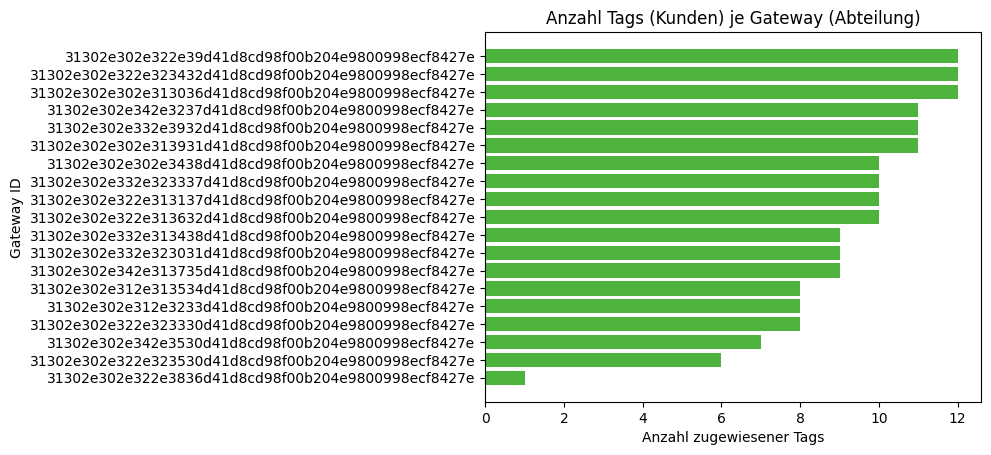

In [4]:
# convert the results to a dataframe
df = pd.DataFrame(results)

# sort the dataframe by tag_count in descending order
df_sorted = df.sort_values(by='tag_count', ascending=True)

# create a horizontal bar chart
plt.barh(df_sorted['gateway_id'], df_sorted['tag_count'], color=mongodb_green)
plt.xlabel('Anzahl zugewiesener Tags')
plt.ylabel('Gateway ID')
plt.title('Anzahl Tags (Kunden) je Gateway (Abteilung)')
plt.show()

## Abfrage 2: In welcher Abteilung gibt es viele Zusammenstöße mit Regalen? 
Die Raumgestaltung der einzelnen Verkaufsabteilungen erscheint ebenfalls interessant. Hohe Beschleunigungswerte werden als "Zusammenstöße mit Regalen" definiert. Als Grenze wurden 200 m/s² festgelegt, was etwas mehr als 20G entspricht. Die X-Achse wird als "Vorne des Einkaufswagens" definiert. Es werden daher lediglich die acc_x Werte visualisiert.

In [5]:
pipeline = [
    # stage 1: filter documents where acc_x is above threshold
    {
        "$match": {
            "acc_x": {"$gt": 200}
        }
    },

    # stage 2: group by gateway_id and count the documents
    {
        "$group": {
            "_id": "$gateway_id",
            "count_acc_x_above_20g": {"$sum": 1}
        }
    }
]

# execute the aggregation query
results_acc_x = list(measures_collection.aggregate(pipeline))

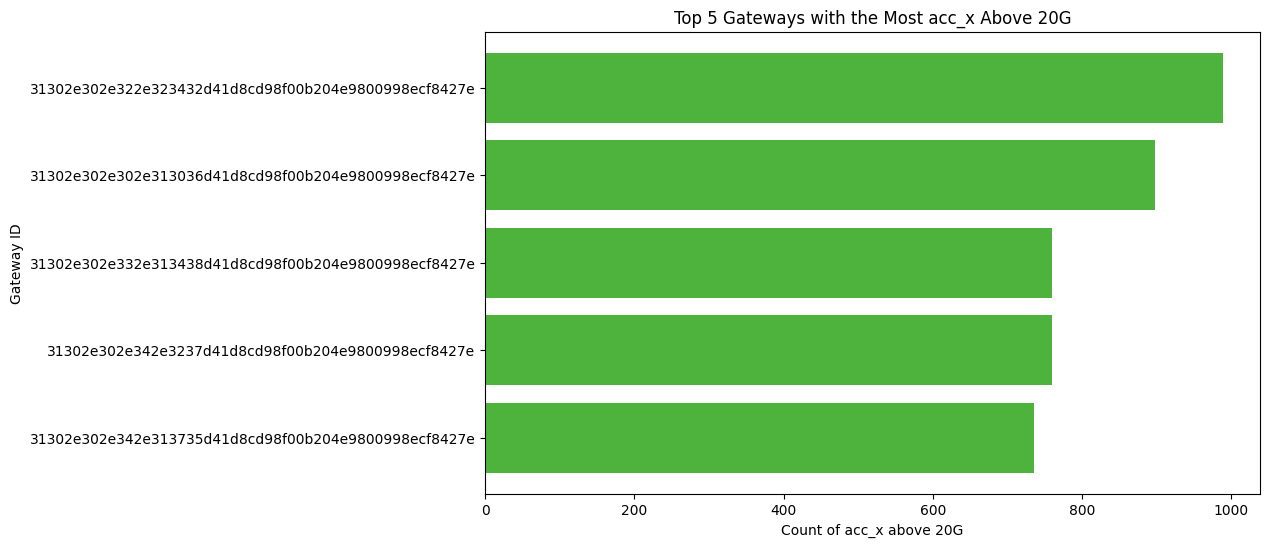

In [6]:
# convert results to a dataframe
df_acc_x_above_threshold = pd.DataFrame(results_acc_x)

# sort the dataframe by the count values and filter on top 5 results
df_sorted_acc_x = df_acc_x_above_threshold.sort_values(by='count_acc_x_above_20g', ascending=False).head(5).sort_values(by='count_acc_x_above_20g', ascending=True)

plt.figure(figsize=(10, 6))
# Plot x data
plt.barh(df_sorted_acc_x['_id'], df_sorted_acc_x['count_acc_x_above_20g'], color=mongodb_green)
plt.xlabel('Count of acc_x above 20G')
plt.ylabel('Gateway ID')
plt.title('Top 5 Gateways with the Most acc_x Above 20G')
plt.show()


## Abfrage 3: Welche Abteilung hat das höchste Kundeninteresse? 
Im Sachzusammenhang des Einkaufens werden große Beschleunigungswerte als Stoppen und wieder Bewegen des Einkaufswagens gedeutet. Höhere durchschnittliche Beschleunigungswerte stellen somit ein höheres Kundeninteresse dar. 

Wie in der vorherigen Abfrage werden somit lediglich die Beschleunigungswerte in X-Achse visualisiert. Es sollen die 5 Top-Abteilungen visualisiert werden.

Zunächst werden die benötigten Daten über eine passende Aggregation abgerufen. Die Daten werden im Anschluss visualisiert.

In [7]:
pipeline = [
    # stage 1: group by gateway_id and calculate average for each field
    {
        "$group": {
            "_id": "$gateway_id",
            "avg_acc_x": {"$avg": "$acc_x"},
            "avg_acc_y": {"$avg": "$acc_y"},
            "avg_acc_z": {"$avg": "$acc_z"}
        }
    }
]

# execute the aggregation query
results = list(measures_collection.aggregate(pipeline))

Im Folgenden werden die Daten visualisiert.

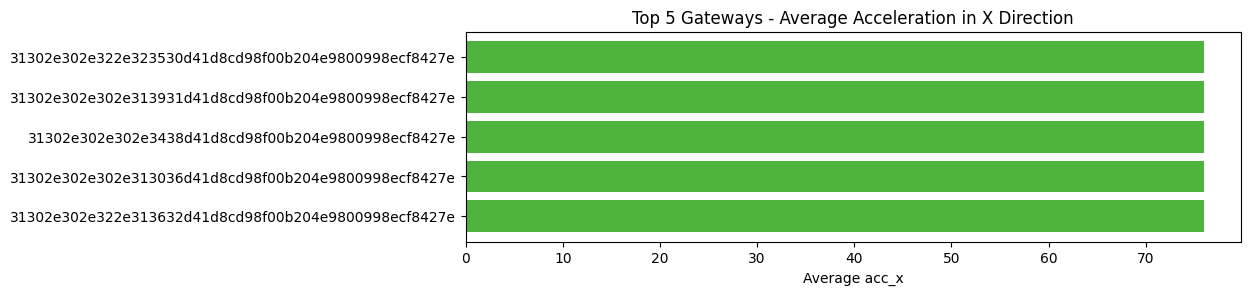

In [8]:
# Convert the results to a pandas DataFrame
df = pd.DataFrame(results)

# Sort the DataFrame by average acceleration values and filter on top 5 results
df_sorted_x = df.sort_values(by='avg_acc_x', ascending=False).head(5).sort_values(by='avg_acc_x', ascending=True)

# Plotting horizontal bar graphs for top 5 gateways
plt.figure(figsize=(10, 6))

# Plot for acc_x
plt.subplot(2, 1, 1)
plt.barh(df_sorted_x['_id'], df_sorted_x['avg_acc_x'], color=mongodb_green)
plt.yticks(df_sorted_x['_id'], df_sorted_x['_id'])
plt.xlabel('Average acc_x')
plt.title('Top 5 Gateways - Average Acceleration in X Direction')

#plt.tight_layout()
plt.show()

## Deep Dive Abfrage 3: Untersuchung der Visualisierung

In der Visualisierung erscheint es so, dass alle Top 5 Gateways identische durchschnittliche Beschleunigungswerte für die X-Achse aufweisen. Nachdem sichergestellt wurde, dass kein Problem in der Datenabfrage und dem Einladen in die Datenbank vorlag, wurde diese Auffälligkeit genauer untersucht.

Zunächst wurden die durchschnittlichen Werte aller Beschleunigungswerte für alle Gateways betrachtet. Es fällt auf, dass alle Daten vollständig identisch sind.

In [9]:
for result in results:
    gateway_id = result["_id"]
    avg_acc_x = result["avg_acc_x"]
    avg_acc_y = result["avg_acc_y"]
    avg_acc_z = result["avg_acc_z"]
    print(f"Gateway ID: {gateway_id}, Average acc_x: {avg_acc_x}, Average acc_y: {avg_acc_y}, Average acc_z: {avg_acc_z}")

Gateway ID: 31302e302e322e313632d41d8cd98f00b204e9800998ecf8427e, Average acc_x: 75.9531012578589, Average acc_y: -4.012274619319261, Average acc_z: 9.81
Gateway ID: 31302e302e322e313137d41d8cd98f00b204e9800998ecf8427e, Average acc_x: 75.95310125785889, Average acc_y: -4.012274619319261, Average acc_z: 9.81
Gateway ID: 31302e302e322e323530d41d8cd98f00b204e9800998ecf8427e, Average acc_x: 75.97893897890495, Average acc_y: -4.01175014099655, Average acc_z: 9.81
Gateway ID: 31302e302e332e323031d41d8cd98f00b204e9800998ecf8427e, Average acc_x: 75.95310125785889, Average acc_y: -4.012274619319261, Average acc_z: 9.81
Gateway ID: 31302e302e342e3237d41d8cd98f00b204e9800998ecf8427e, Average acc_x: 75.95310125785889, Average acc_y: -4.012274619319261, Average acc_z: 9.81
Gateway ID: 31302e302e322e39d41d8cd98f00b204e9800998ecf8427e, Average acc_x: 75.95310125785889, Average acc_y: -4.012274619319261, Average acc_z: 9.81
Gateway ID: 31302e302e332e313438d41d8cd98f00b204e9800998ecf8427e, Average acc_

Es ist zu erkennen, dass für alle Beschleunigungsrichtungen alle Durchschnittswerte identisch sind. Zur Überprüfung dieser Auffälligkeit wurde weiter die Abfrage 2 ohne Filter auf die Top-5-Gateways mit der Gesamtzahl an Measures je Gateway verglichen. Für diese weitere Abfrage musste lediglich stage 1 entfernt werden.

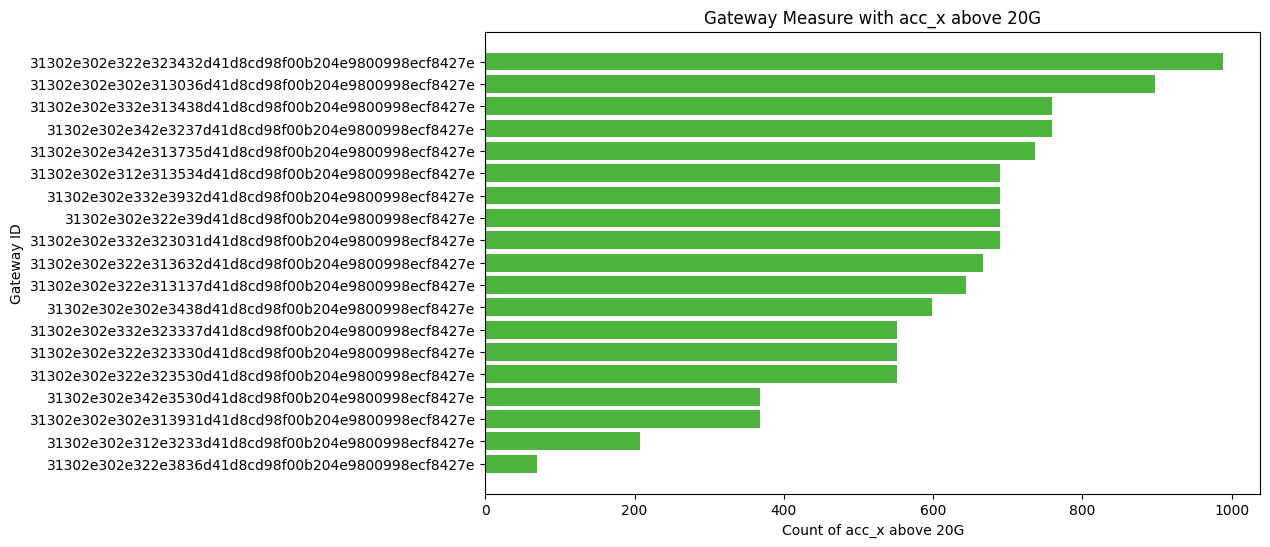

In [10]:
# copy of query 2
pipeline = [
    # stage 1: Filter documents where acc_x is above the threshold
    {
        "$match": {
            "acc_x": {"$gt": 200}
        }
    },
    # Stage 2: Group by gateway_id and count the documents
    {
        "$group": {
            "_id": "$gateway_id",
            "count_acc_x_above_20g": {"$sum": 1}
        }
    }
]

# Execute the aggregation query
results_acc_x = list(measures_collection.aggregate(pipeline))

# convert the results to a pandas DataFrame
df_acc_x_above_threshold = pd.DataFrame(results_acc_x)

# Sort the DataFrame by the count values and filter on top 5 results
df_sorted_acc_x = df_acc_x_above_threshold.sort_values(by='count_acc_x_above_20g', ascending=False).sort_values(by='count_acc_x_above_20g', ascending=True)

plt.figure(figsize=(10, 6))
# Plot x data
plt.barh(df_sorted_acc_x['_id'], df_sorted_acc_x['count_acc_x_above_20g'], color=mongodb_green)
plt.xlabel('Count of acc_x above 20G')
plt.ylabel('Gateway ID')
plt.title('Gateway Measure with acc_x above 20G')
plt.show()


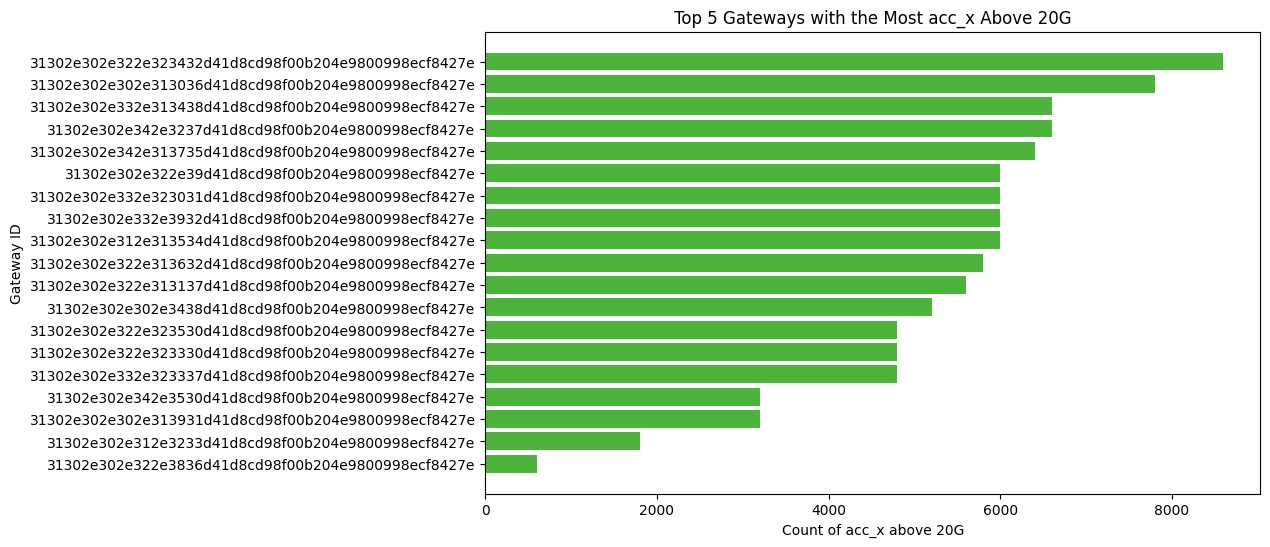

In [11]:
pipeline = [
    # stage 2: group by gateway_id and count the documents
    {
        "$group": {
            "_id": "$gateway_id",
            "count_acc_x_above_20g": {"$sum": 1}
        }
    }
]

# execute the aggregation query
results_acc_x = list(measures_collection.aggregate(pipeline))

# convert results to a dataframe
df_acc_x_above_threshold = pd.DataFrame(results_acc_x)

# sort the dataframe by the count values and filter on top 5 results
df_sorted_acc_x = df_acc_x_above_threshold.sort_values(by='count_acc_x_above_20g', ascending=False).sort_values(by='count_acc_x_above_20g', ascending=True)

plt.figure(figsize=(10, 6))
# Plot x data
plt.barh(df_sorted_acc_x['_id'], df_sorted_acc_x['count_acc_x_above_20g'], color=mongodb_green)
plt.xlabel('Count of acc_x above 20G')
plt.ylabel('Gateway ID')
plt.title('Top 5 Gateways with the Most acc_x Above 20G')
plt.show()


Es fällt auf, dass die Darstellungen bis auf die Skalierung der X-Achse identisch sind. Das führte zur Vermutung, dass ein Muster in der Datenerstellung vorliegt. Diese Vermutung wurde untersucht, indem die Anzahl an unterschiedlichen Messungen betrachtet wurde.

In [12]:
pipeline = [
    # stage 1: group by acc_x and count documents
    {
        "$group": {
            "_id": "$acc_x",
            "count": {"$sum": 1}
        }
    }
]

# execute the aggregation query
results = list(measures_collection.aggregate(pipeline))

# print the results
for result in results:
    acc_x = result["_id"]  # Use _id directly as acc_x
    count = result["count"]
    print(f"acc_x: {acc_x}, Count: {count}")


acc_x: 2.395363985801791, Count: 499
acc_x: 2.3922831897525234, Count: 499
acc_x: 29.60287414132112, Count: 499
acc_x: 0.20245073768240182, Count: 499
acc_x: 153.63250369670993, Count: 499
acc_x: 117.86868923033636, Count: 499
acc_x: 91.51416893057286, Count: 499
acc_x: 17.769866158680585, Count: 499
acc_x: 149.2155666122558, Count: 499
acc_x: 30.532052887662214, Count: 499
acc_x: 220.29476631732388, Count: 499
acc_x: 0.35540818668762664, Count: 499
acc_x: 3.5125838063761012, Count: 499
acc_x: 7.6757219720450625, Count: 499
acc_x: 281.1756519839509, Count: 499
acc_x: 102.27988118483218, Count: 499
acc_x: 214.41694225947387, Count: 499
acc_x: 4.215602130902937, Count: 499
acc_x: 0.38651526237689027, Count: 499
acc_x: 5.752983843951737, Count: 499
acc_x: 15.589604169094954, Count: 499
acc_x: 327.74814129321305, Count: 499
acc_x: 1.046951235351477, Count: 499
acc_x: 178.10540756568702, Count: 499
acc_x: 158.85015033575894, Count: 499
acc_x: 55.67207839943804, Count: 499
acc_x: 21.57495865

Es ist zu erkennen, dass jeder Messwert identisch häufig in den Daten vorhanden ist. Nach weiteren Unterschungen, die an dieser Stelle ausgespart werden, wurde festgestellt, dass augenscheinlich identische Daten zyklisch erstellt werden und lediglich die Gateway-Tag-Zuordnung wechselt.

Das zyklische Erzeugen der Daten führt dazu, dass die "Events über 20G in X-Richtung" bis auf die Skalierung der X-Achse visualisiert identisch sind zur Gesamtanzahl an Messwerten an einem Gateway. Einige Gateway-Tag-Verbindungen haben augenscheinlich mehr Measures-Zyklen durchlaufen als andere. Ebenfalls führt dieses zyklische Erzeugen der Messwerte dazu, dass die Durchschnittswerte der Beschleunigung für alle Gateways identisch sind.

## Abfrage 4: Wie lange verbringt ein Kunde in einer Abteilung?
Technisch ist zu ermitteln, zu welchem Zeitpunkt Gateway-Tag-Wechsel stattfinden, um anschließend die durchschnittliche Zeit einer Gateway-Tag-Verbindung zu ermitteln. Dazu sind mehrere Schritte nötig. Die unteren Schritte sind entsprechend im Code kommentiert. 

1. Die Daten werden abgefragt und nach recorded_time sortiert.
2. Die Differenz der recorded_time zur nun sortierten vorherigen Zeile, gruppiert nach Gateway-ID und Tag-ID, wird ermittelt.
3. Alle Differenzen, die größer als 1 Minute sind, werden als "Connection Events" und damit als neue Session definiert (1 in der Spalte new_connection_event).
4. Die Spalte connection_event_group kumuliert die Summe der Connection Events, ebenfalls gruppiert nach Gateway-ID und Tag-ID. Jede connection_event_group stellt somit eine Session der Verbindung zwischen Gateway-ID und Tag-ID dar. 
5. Für jede Gruppierung aus gateway_id und connection_event_group wird eine Durchschnittszeitszeit ermittelt.
6. Anschließend wird auf Basis dieser Session-Durchschnittszeiten die Durchschnittszeit eines Gateways ermittelt. 

In [13]:
# step 1: get and sort the data
# define a projection to retrieve only the desired fields
projection = {
    "_id": 0,
    "recorded_time": 1,
    "gateway_id": 1,
    "tag_id": "$tag_address",
}

# get documents with the specified projection
cursor = measures_collection.find({}, projection)

# convert the cursor to a list and then to a dataframe for easier handling
measures_df = pd.DataFrame(list(cursor))

# sort the dataframe by recorded_time
measures_df.sort_values(by="recorded_time", inplace=True)

# step 2: calculate the time difference between consecutive records for the same tag_id and gateway_id
measures_df["time_diff"] = measures_df.groupby(["tag_id", "gateway_id"])["recorded_time"].diff()

# step 3: identify distinct connection events (cases where the time difference is greater than 1 minute)
time_threshold = pd.Timedelta(minutes = 1)
measures_df["new_connection_event"] = (measures_df["time_diff"] > time_threshold).astype(int)

# step 4: cumulative sum of new_connection_event to create groups
measures_df["connection_event_group"] = measures_df.groupby("gateway_id")["new_connection_event"].cumsum()

# step 5: calculate the total connection time for each gateway_id and connection_event_group
total_connection_time = measures_df.groupby(["gateway_id", "connection_event_group"])["recorded_time"].agg(["min", "max"]).reset_index()

# step 6: calculate the average connection time for each gateway_id
average_connection_time = total_connection_time.copy()
average_connection_time["duration"] = average_connection_time["max"] - average_connection_time["min"]
average_connection_time["average_connection_time"] = average_connection_time["duration"] / pd.Timedelta(seconds=1)  # Convert to seconds for average

Nach der Ermittlung der Durchschnittszeit, werden die Ergebnisse durch den folgenden Code-Block visualisiert.

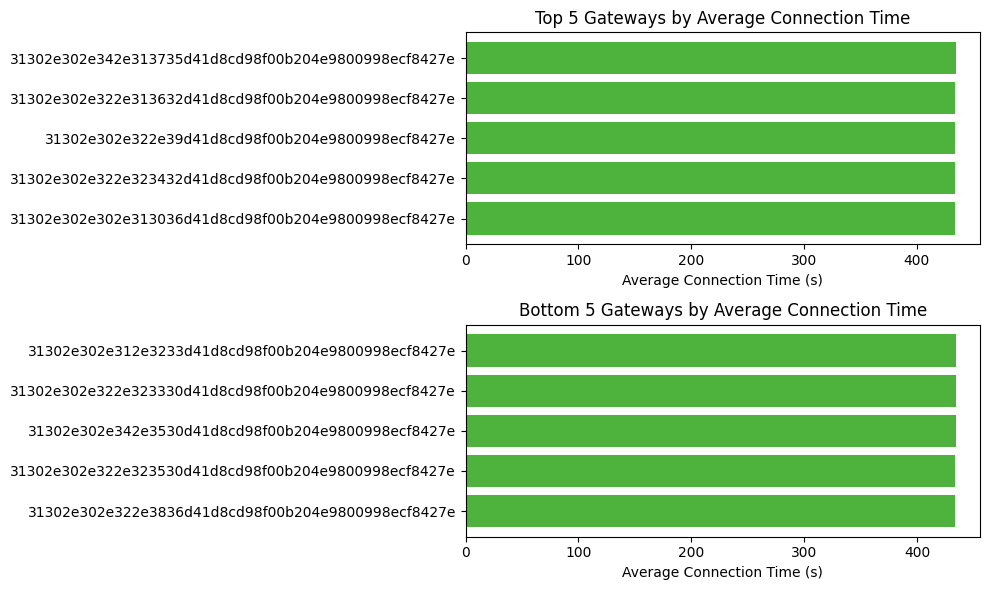

In [14]:
# sort the dataframe by average_connection_time in descending order
average_connection_time_sorted = average_connection_time.sort_values(by='average_connection_time', ascending=False)

# top and bottom 5 gateways
top5_gateways = average_connection_time_sorted.head(5).sort_values(by='average_connection_time', ascending=True)
bottom5_gateways = average_connection_time_sorted.tail(5).sort_values(by='average_connection_time', ascending=True)

# visualization
plt.figure(figsize=(10, 6))

# top 5
plt.subplot(2, 1, 1)
plt.barh(top5_gateways['gateway_id'], top5_gateways['average_connection_time'], color=mongodb_green)
plt.yticks(top5_gateways['gateway_id'], top5_gateways['gateway_id'])
plt.xlabel('Average Connection Time (s)')
plt.title('Top 5 Gateways by Average Connection Time')

# bottom 5
plt.subplot(2, 1, 2)
plt.barh(bottom5_gateways['gateway_id'], bottom5_gateways['average_connection_time'], color=mongodb_green)
plt.yticks(bottom5_gateways['gateway_id'], bottom5_gateways['gateway_id'])
plt.xlabel('Average Connection Time (s)')
plt.title('Bottom 5 Gateways by Average Connection Time')

# adjust layout
plt.tight_layout()
plt.show()

Die Darstellung erinnert an die Darstellung der durchschnittlichen Beschleunigungswerte. Tiefere Untersuchungen dieser Auffälligkeit werden innerhalb dieses Notebooks ebenfalls ausgespart. Die obere Visualisierung ist aber ebenfalls auf ein Muster in der Datengenerierung zurückzuführen. Bei Betrachtung der genauen Werte liegen lediglich Unterschiede im Millisekundenbereich vor. 

In [15]:
print(average_connection_time_sorted[["gateway_id", "average_connection_time"]])

                                           gateway_id  average_connection_time
16  31302e302e342e313735d41d8cd98f00b204e9800998ec...                  434.424
6   31302e302e322e313632d41d8cd98f00b204e9800998ec...                  434.335
11   31302e302e322e39d41d8cd98f00b204e9800998ecf8427e                  434.249
0   31302e302e302e313036d41d8cd98f00b204e9800998ec...                  434.214
8   31302e302e322e323432d41d8cd98f00b204e9800998ec...                  434.214
14  31302e302e332e323337d41d8cd98f00b204e9800998ec...                  434.197
2   31302e302e302e3438d41d8cd98f00b204e9800998ecf8...                  434.197
5   31302e302e322e313137d41d8cd98f00b204e9800998ec...                  434.197
1   31302e302e302e313931d41d8cd98f00b204e9800998ec...                  434.197
15  31302e302e332e3932d41d8cd98f00b204e9800998ecf8...                  434.197
17  31302e302e342e3237d41d8cd98f00b204e9800998ecf8...                  434.196
13  31302e302e332e323031d41d8cd98f00b204e9800998ec..